In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import requests

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

Using cuda


# Data

In [3]:
url_xtrain = (
    "https://drive.google.com/uc?&id="
    "1PMzjODVFblVnwq8xo7pKHrdbczPxdqTa&export=download"
)

url_xtest = (
    "https://drive.google.com/uc?&id="
    "1OcNc0YQsOMw9jQIIHgiOXVG03wjXbEiM&export=download"
)
url_ytest = (
    "https://drive.google.com/uc?&id="
    "19vR0QvKluuiIT2H5mCFNIJh6xGVwshDd&export=download"
)

response = requests.get(url_xtrain)
with open("xtrain.npy", "wb") as f:
    f.write(response.content)

response = requests.get(url_xtest)
with open("xtest.npy", "wb") as f:
    f.write(response.content)
    
response = requests.get(url_ytest)
with open("ytest.npy", "wb") as f:
    f.write(response.content)

In [4]:
X_train = np.load("xtrain.npy")
X_test = np.load("xtest.npy")
y_test = np.load("ytest.npy")

X_train = X_train[:10000]
X_test = X_test[:10000]
y_test = y_test[:10000]

In [5]:
# Preparing the data
def prepare_data(*data):
    # return tensors on device
    return (torch.tensor(d, dtype=torch.float32, device=device) for d in data)

In [6]:
winsize = 512
stride = 1

train_windows = np.lib.stride_tricks.sliding_window_view(X_train, winsize, axis=0)[::stride].transpose(0, 2, 1)
test_windows = np.lib.stride_tricks.sliding_window_view(X_test, winsize, axis=0)[::stride].transpose(0, 2, 1)
test_labels = np.lib.stride_tricks.sliding_window_view(y_test, winsize, axis=0)[::stride]

In [7]:
train_windows, test_windows, test_labels = prepare_data(train_windows, test_windows, test_labels)

# Model

In [8]:
# Creating an lstm autoencoder in PyTorch
# The model takes in multiple time series of size (n_time_steps, n_features) and returns the reconstructed time series

# Input : (batch_size, n_time_steps, n_features)
# Output: (batch_size, n_time_steps, n_features)

class LSTM_Autoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTM_Autoencoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.decoder = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=n_features,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.encoder(x)
        x, (_, _) = self.decoder(x)

        return x

In [9]:
from tqdm.autonotebook import tqdm

model = LSTM_Autoencoder(seq_len=winsize, n_features=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 20

ti = tqdm(range(n_epochs), desc="Epoch", leave=True)
for epoch in ti:
    model.train()
    train_loss = 0.0
    # Using only x1 for training
    for x in train_windows:
        optimizer.zero_grad()
        x = x.to(device)
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_windows)
    ti.set_postfix(train_loss=f"{train_loss:.6f}")
    # print(f"Epoch {epoch+1}: Train loss {train_loss}")
    

/tmp/ipykernel_28586/3552384068.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/storage/store/work/jyehya/anaconda/envs/benchopt/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 55])) that is different to the input size (torch.Size([1, 512, 55])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch: 100%|██████████| 20/20 [18:52<00:00, 56.64s/it, train_loss=0.000075]


In [10]:
model.eval()

pred2 = model(test_windows[0].unsqueeze(0)).squeeze().detach().cpu().numpy()
test_windows[0].shape, pred2.shape

(torch.Size([512, 55]), (512, 55))

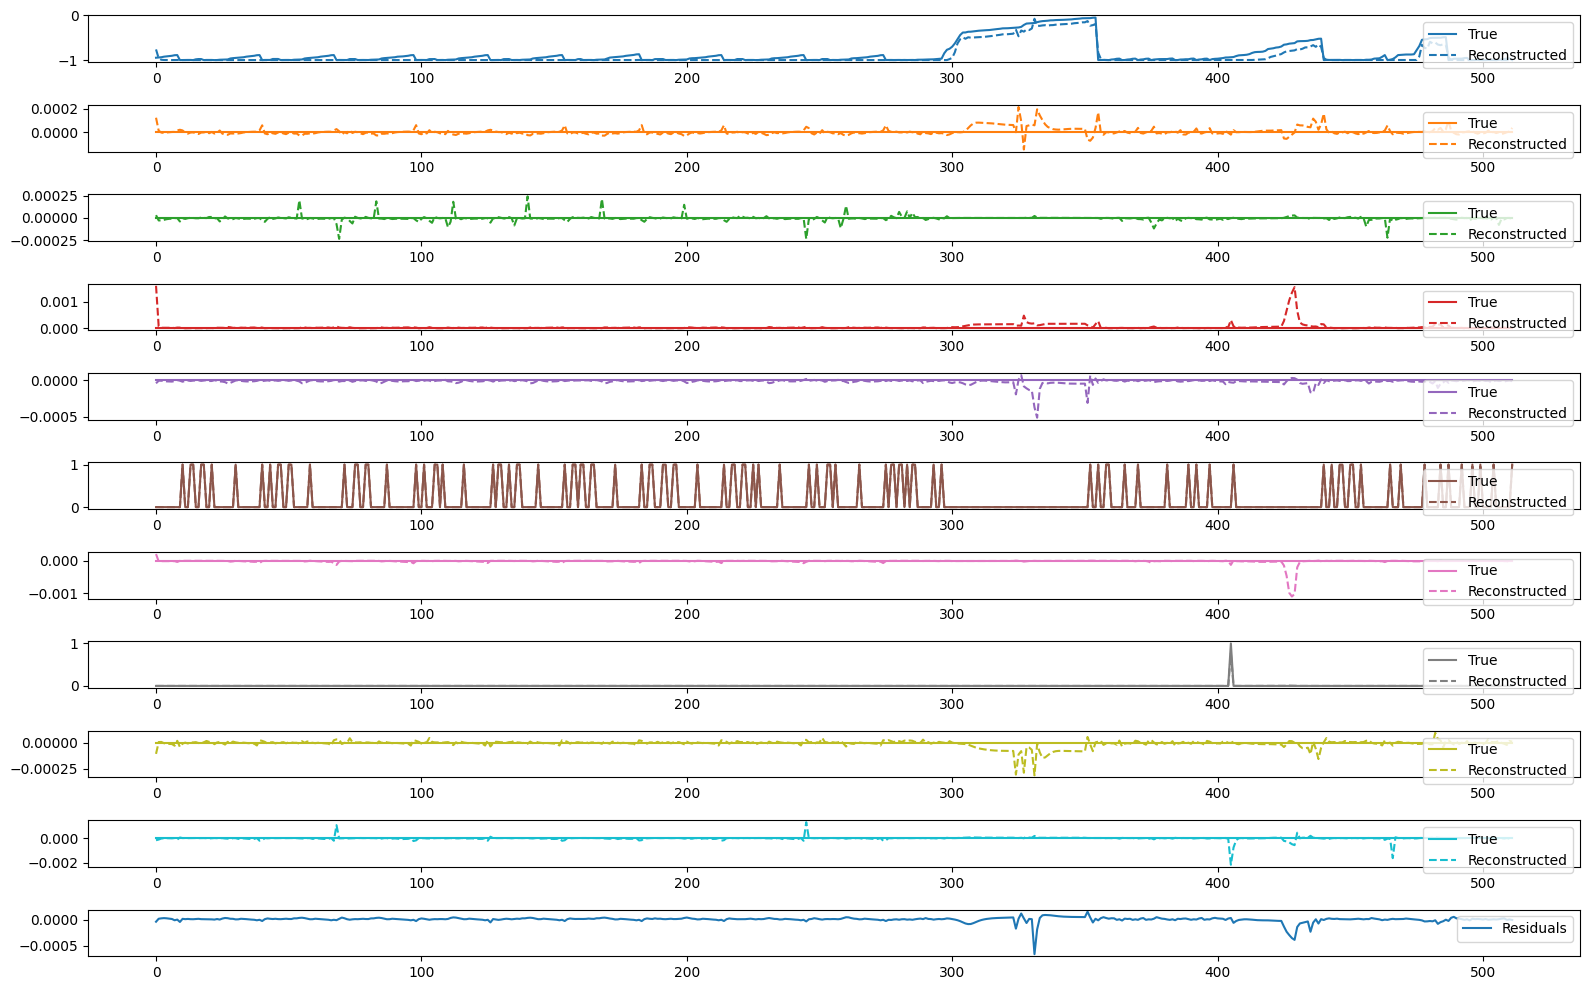

In [11]:
colors = plt.rcParams["axes.prop_cycle"]()

figs, axs = plt.subplots(11, 1, figsize=(16, 10))

for i in range(10):
    ax = axs[i]
    color = next(colors)["color"]
    ax.plot(test_windows[0, :, i].detach().cpu(), label="True", color=color)
    ax.plot(pred2[:, i], label="Reconstructed", color=color, linestyle="--")
    ax.legend(loc="upper right")
    for j in range(len(pred2)):
        if y_test[j] == 1:
            ax.axvline(j, color="red", alpha=0.3)

# Plot the residuals for the last feature
ax = axs[10]
color = next(colors)["color"]
ax.plot(test_windows[0, :, 10].detach().cpu() - pred2[:, 10], label="Residuals", color=color)
ax.legend(loc="upper right")
for j in range(len(pred2)):
    if y_test[j] == 1:
        ax.axvline(j, color="red", alpha=0.3)
        
plt.tight_layout()
    
plt.show()